__import functions__
import all functions from the lessons

In [1]:
from class_functions import * 

__Import and format the training set of images. Display and make sure that : __
1. they are the proper images for each sets (cars and non-cars are in the right bin) 
2. They are the right format (between 0 and 1 as we will normalize the jpeg data to be between 0 and 1 as well) 

Import all the tools to deal with video and define a function that grabs a set of test frames from the video 

8792 8968


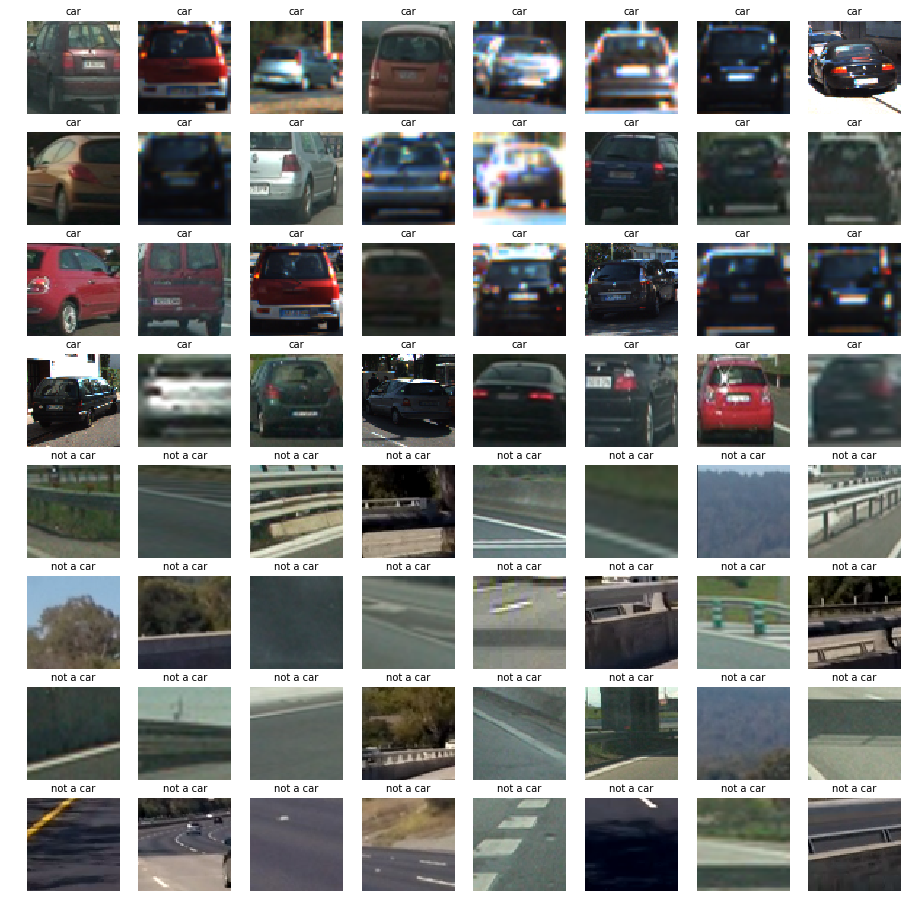

In [2]:
import glob
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt


def display_random_images(img_paths):
    car_images = img_paths[0]
    noncar_images = img_paths[1]
    fig, axs = plt.subplots(8,8, figsize=(16, 16))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # Step through the list and search for chessboard corners
    for i in np.arange(32):
        img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('car', fontsize=10)
        axs[i].imshow(img)
    for i in np.arange(32,64):
        img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('not a car', fontsize=10)
        axs[i].imshow(img)

def grab_video_sample(path_to_file= "", sample_length=10):
    if path_to_file == "":
        raise TypeError('empty path')
    pass

#make sure everything is in RGB colorspace from the start
def read_image(path):
    img= cv2.imread(path)
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

car_images = glob.glob('sample_data/vehicles/**/*.png')
noncar_images = glob.glob('sample_data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))
display_random_images([car_images,noncar_images])

__Extract features__

1. First make sure all the feature extraction function are working as expected
2. Define a feature extraction function that implements the efficient way for HOG
This function returns a feature vector containing : histograms of colors, spatial color bins and HOG 

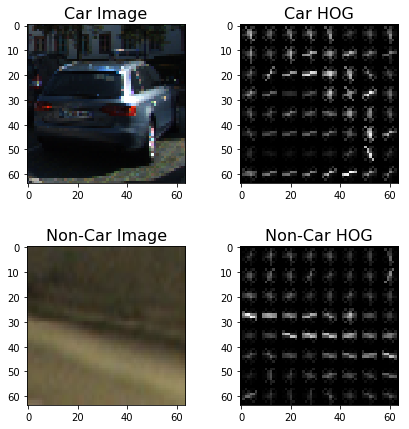

In [3]:
#extract and visualise HOG features 

#NOTE: extract_hog() function was created in a separate file, its imported at the begining of this notebook
random_idx= np.random.randint(np.min([len(car_images),len(noncar_images)]))
car_img = read_image(car_images[random_idx - 1])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = read_image(noncar_images[random_idx])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

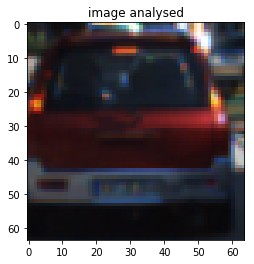

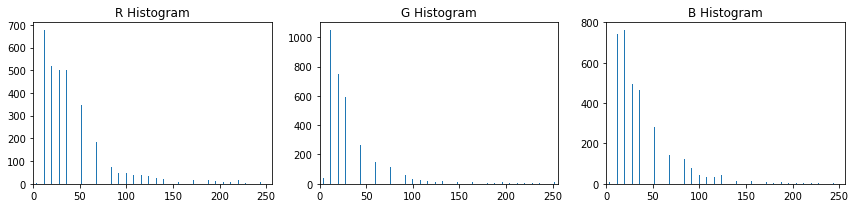

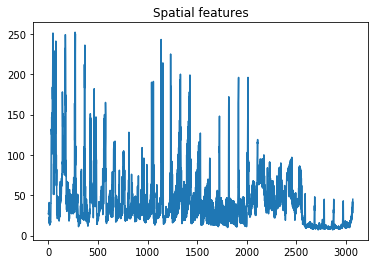

In [4]:
#extract and visualise color features (Spacial bins and color histograms)
random_idx= np.random.randint(np.min([len(car_images),len(noncar_images)]))
car_img = read_image(car_images[random_idx - 1])

#get the features
spatial_features = bin_spatial(car_img, size=(32, 32))
#_,_,_,_,hist_features = color_hist(car_img, nbins=32, bins_range=(0, 256))

#visualize
rh, gh, bh, bincen, feature_vec = color_hist(car_img, nbins=32, bins_range=(0, 256))

plt.figure()
plt.imshow(car_img)
plt.title('image analysed')

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
plt.figure()
plt.plot(spatial_features)
plt.title('Spatial features')

__train a classifier using the samples__

In [5]:
#the following function was copied from the class material but was slightly modified to read images constistently with the
#rest of the code in this project, using the read_image function

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_image(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            _,_,_,_,hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

#create labels and randomize (shuffles) data 
def get_training_and_test_data(car_images, noncar_images):
    
    #extract features from car images and create y labels
    car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    X = np.vstack((car_features, notcar_features)).astype(np.float32)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))

    return  X_train, X_test, y_train, y_test

def normalized(data,scaler):
    return scaler.transform(data)

In [7]:
#all the parameters are defined here
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#xy_window= (92, 92) #size (width, height) of the sliding windows
y_start_stop = [400, None] # Min and max in y to search in slide_window()

In [8]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = get_training_and_test_data(car_images, noncar_images)
X_scaler = StandardScaler().fit(X_train)
clf = LinearSVC()
clf.fit(normalized(X_train,X_scaler), y_train)
print('Test Accuracy of SVC = ', round(clf.score(normalized(X_test,X_scaler), y_test), 4))

Test Accuracy of SVC =  0.987


__make a function that takes a video frame and returns a list of raw bounding boxes with positive detections using the classifier__

In [9]:
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=False, hist_feat=False, hog_feat=True):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            if spatial_feat or hist_feat :
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                spatial_features= np.empty(0)
                hist_features =np.empty(0)
                # Get color features
                if spatial_feat:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                if hist_feat:
                    _,_,_,_,hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
  
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))            
            else:
                test_features = X_scaler.transform(hog_features.reshape(1, -1))
                
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

__Test the car finding algorithm using a specific scale and restricted ROI__

In [10]:
test_img = read_image('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(test_img, ystart, ystop, scale, color_space, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


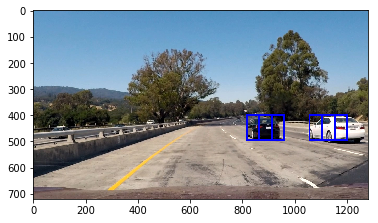

In [11]:
plt.imshow(draw_boxes(test_img,rectangles))

__Implement different size of sliding windows__

The following function shall define different values of ystart, ystop and scale and run the car finding algorithm for each set. It shall return a list of resulting bounding boxes as a result of the search

In [12]:
#define different sets of ROI with different scales
params= [{'ystart':400,'ystop':465, 'scale':1.0},
 {'ystart':415,'ystop':480, 'scale':1.0},
{'ystart':430,'ystop':495, 'scale':1.5},
{'ystart':400,'ystop':530, 'scale':1.5},
{'ystart':430,'ystop':560, 'scale':2.0},
{'ystart':400,'ystop':595, 'scale':3.5},
{'ystart':465,'ystop':660, 'scale':3.5}]

# the following function uses a list defining different scales and different ROI and returns the rectangles
# where vehicles were found
def sliding_windows(img,params,color_space, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=False, hist_feat=False, hog_feat=True):
    rectangles= []
    for val in params:
        rectangles.extend(find_cars(img, val['ystart'], val['ystop'], val['scale'], color_space, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
    return rectangles

it took  0.6159155368804932  seconds to compute the rectangles


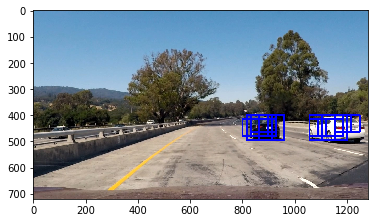

In [13]:
import time
tick=time.time()
hot_windows = sliding_windows(test_img,params,color_space, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
tack=time.time()
print('it took ',tack-tick,' seconds to compute the rectangles')
plt.imshow(draw_boxes(np.copy(test_img),hot_windows))

__make and display heatmap of the results obtained with the sliding windows__ 

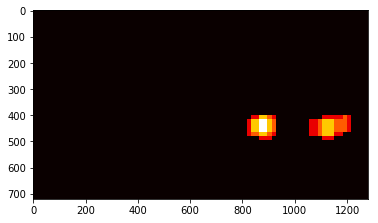

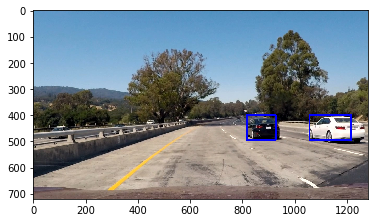

In [14]:
#get heatmap using function given in class
heatmap = np.zeros_like(cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY))
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap, 1)
plt.imshow(heatmap,cmap=plt.get_cmap('hot'))
plt.figure()
plt.imshow(draw_labeled_bboxes(np.copy(test_img), heatmap))

In [15]:
class rectangle_container():
    def __init__(self,depth=15):
        self.rectangles=[]
        self.depth = depth
    
    def add_rectangles(self,rect):
        self.rectangles.append(rect)
        if len(self.rectangles) > self.depth : 
            self.rectangles = self.rectangles[-self.depth:]
        
    def get_rectangles(self):
        return [item for sublist in self.rectangles for item in sublist]

def process_frame(video_frame,params,rectangles_container,color_space, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=False, hist_feat=False, hog_feat=True):
    
    if rectangles_container is not None:
        rectangles_container.add_rectangles(sliding_windows(video_frame,params,color_space, hog_channel, clf, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
                                            
        heatmap = np.zeros_like(cv2.cvtColor(video_frame,cv2.COLOR_BGR2GRAY))
        heatmap = add_heat(heatmap, rectangles_container.get_rectangles())
        
    else: 
        rectangles = sliding_windows(video_frame,params,color_space, hog_channel, clf, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        heatmap = np.zeros_like(cv2.cvtColor(video_frame,cv2.COLOR_BGR2GRAY))
        heatmap = add_heat(heatmap, rectangles)
        
    heatmap = apply_threshold(heatmap, 17)

    return draw_labeled_bboxes(video_frame, heatmap)

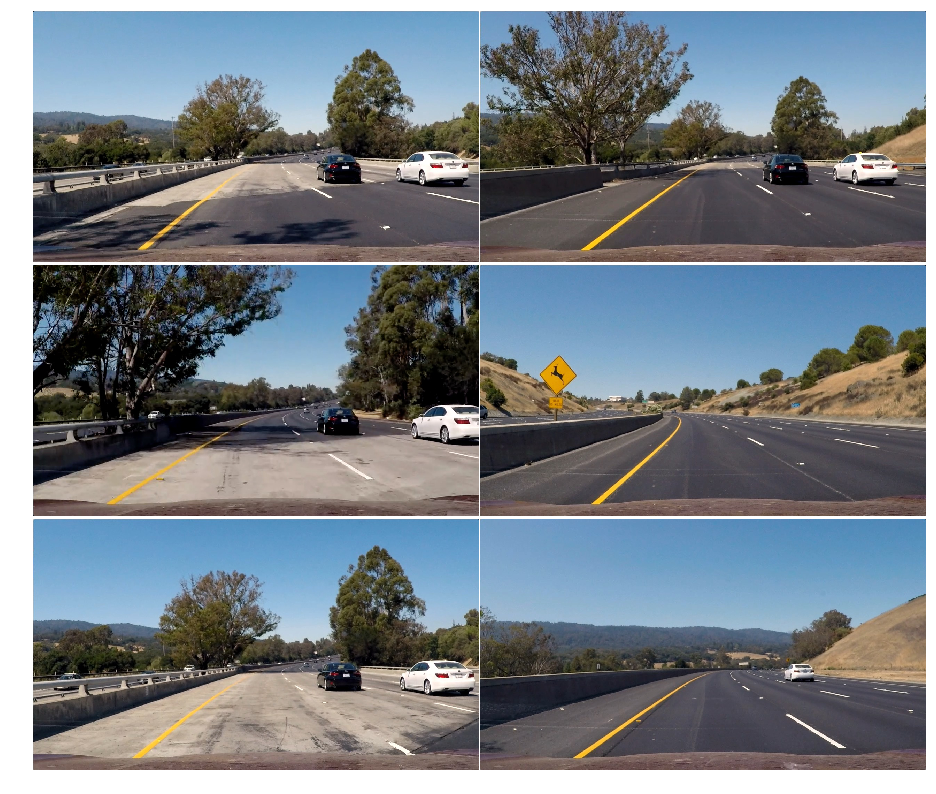

In [16]:
#test pipeline on all test images
test_images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    result = process_frame(read_image(im),params,None,color_space, hog_channel, clf, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,
                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    axs[i].imshow(result)
    axs[i].axis('off')

In [17]:
#run simple pipeline on video  (first version)
from moviepy.editor import VideoFileClip
rect_cont  = rectangle_container(depth=10)
def process_frame_wrapper(frame):
    return process_frame(frame,params,rect_cont,color_space, hog_channel, clf, X_scaler, orient, 
                           pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False,
                           spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

test_out_file = 'test_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame_wrapper) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


100%|█████████▉| 1260/1261 [11:06<00:00,  1.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 11min 53s, sys: 3.77 s, total: 11min 57s
Wall time: 11min 8s
